# Comparing the Filter with a MiniGNN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pytorch_lightning import Trainer
from pytorch_lightning import LightningModule
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

sys.path.append("../../")
from Pipelines.Common_Tracking_Example.LightningModules.GNN.Models.interaction_gnn import InteractionGNN
device = "cuda" if torch.cuda.is_available() else "cpu"

import warnings
warnings.filterwarnings("ignore")

In [5]:
with open("mini_gnn.yaml") as f:
    hparams = yaml.load(f, Loader=yaml.FullLoader)

In [6]:
model = InteractionGNN(hparams)

### Dataset

In [159]:
%%time
model.setup(stage="fit")

CPU times: user 8.75 ms, sys: 7.96 ms, total: 16.7 ms
Wall time: 15 ms


In [160]:
sample = model.trainset[0]

/global/homes/d/danieltm/.conda/envs/exatrkx-gpu/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

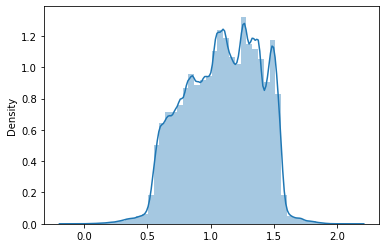

In [155]:
def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1.0 * np.log(np.tan(theta / 2.0))

eta = calc_eta(sample.x[:, 0], sample.x[:, 2])
sns.distplot(eta[sample.edge_index[0]])

In [161]:
sample

Data(x=[323626, 3], cell_data=[323626, 11], pid=[323626], event_file='/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000015707', hid=[323626], pt=[323626], primary=[323626], nhits=[323626], modules=[323626], modulewise_true_edges=[2, 127305], signal_true_edges=[2, 14915], edge_index=[2, 4854491], y=[4854491], y_pid=[4854491], pid_signal=[4854491])

In [162]:
print(f"Input efficiency: {sample.y.sum() / sample.signal_true_edges.shape[1]}, Input purity: {sample.y.sum() / sample.y.shape[0]}")

Input efficiency: 0.9888032078742981, Input purity: 0.0030380114912986755


### Memory Test

In [187]:
%%time
model.setup(stage="fit")
sample = model.trainset[0].to(device)
model = model.to(device)

CPU times: user 23.9 s, sys: 815 ms, total: 24.7 s
Wall time: 634 ms


In [188]:
torch.cuda.reset_peak_memory_stats()
output = model(sample.x.to(device), sample.edge_index.to(device))

In [189]:
print(torch.cuda.max_memory_allocated() / 1024**3, "Gb")

14.926893711090088 Gb


### Train GNN

In [7]:
logger = WandbLogger(project=hparams["project"], group="InitialTest")   
trainer = Trainer(gpus=1, max_epochs=hparams["max_epochs"], logger=logger)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: murnanedaniel. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | node_encoder           | Sequential | 66.8 K
1 | edge_encoder           | Sequential | 262 K 
2 | edge_network           | Sequential | 328 K 
3 | node_network           | Sequential | 197 K 
4 | output_edge_classifier | Sequential | 328 K 
------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.736     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]